In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df = pd.read_csv("../data/wikidata_artists.csv")
df

,artist,country,type,genre,award,birth,death,gender
0,13,NaN,album,new wave,álbum,NaN,NaN,Unknown
1,13,NaN,album,new wave,album de diamant du SNEP,NaN,NaN,Unknown
2,13,NaN,album,new wave,תואר יהלום מ-SNEP,NaN,NaN,Unknown
3,13,NaN,album,new wave,diamantalbum enligt SNEP,NaN,NaN,Unknown
4,13,NaN,album,new wave,diamantni album SNEP,NaN,NaN,Unknown
...,...,...,...,...,...,...,...,...
1029552,Özdemir Erdoğan,Turkey,human,jazz,statlig konstnär i Turkiet,1940-06-17T00:00:00Z,NaN,male
1029553,Özdemir Erdoğan,Turkey,human,jazz,Devlet Sanatçısı,1940-06-17T00:00:00Z,NaN,male
1029554,Özdemir Erdoğan,Turkey,human,jazz,державний артист,1940-06-17T00:00:00Z,NaN,male
1029555,Özdemir Erdoğan,Turkey,human,jazz,artiste national,1940-06-17T00:00:00Z,NaN,male


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029557 entries, 0 to 1029556
Data columns (total 8 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   artist   1029557 non-null  object
 1   country  867348 non-null   object
 2   type     1029557 non-null  object
 3   genre    926248 non-null   object
 4   award    1029557 non-null  object
 5   birth    868474 non-null   object
 6   death    335799 non-null   object
 7   gender   1029557 non-null  object
dtypes: object(8)
memory usage: 62.8+ MB


In [42]:
df.isnull().sum()

artist          0
country    162209
type            0
genre      103309
award           0
birth      161083
death      693758
gender          0
dtype: int64

In [43]:
df['country'].value_counts()

country
United States     367675
United Kingdom    100718
Canada             41333
France             38695
Soviet Union       37632
                   ...  
Troy                   9
Georgia                9
Ethiopia               8
Ivory Coast            5
Croatia                3
Name: count, Length: 139, dtype: int64

In [44]:
df['country'] = df['country'].fillna('Unknown')

In [45]:
df['death'] = df['death'].notna()  # Convierte valores no nulos en True y los nulos en False
df['death'].value_counts()

death
False    693758
True     335799
Name: count, dtype: int64

In [46]:
df['death'] = df['death'].map({False: 'alive', True: 'deceased'})
df['death'].value_counts()

death
alive       693758
deceased    335799
Name: count, dtype: int64

In [47]:
df['genre'].value_counts()

genre
classical music             64448
pop music                   61765
rock music                  39150
opera                       37079
jazz                        30859
                            ...  
short film                      1
psychological drama film        1
true crime                      1
history book                    1
essay film                      1
Name: count, Length: 812, dtype: int64

In [49]:
df['birth'] = df['birth'].fillna('Unknown')

In [61]:
df = df.drop(columns= ['genre'])

In [62]:
df.isnull().sum()

artist     0
country    0
type       0
award      0
birth      0
death      0
gender     0
dtype: int64

In [63]:
df.head()

,artist,country,type,award,birth,death,gender
0,13,Unknown,album,álbum,Unknown,alive,Unknown
1,13,Unknown,album,album de diamant du SNEP,Unknown,alive,Unknown
2,13,Unknown,album,תואר יהלום מ-SNEP,Unknown,alive,Unknown
3,13,Unknown,album,diamantalbum enligt SNEP,Unknown,alive,Unknown
4,13,Unknown,album,diamantni album SNEP,Unknown,alive,Unknown


In [64]:
duplicados = df.duplicated()

print(df[duplicados])

               artist  country   type  \
6                  13  Unknown  album   
7                  13  Unknown  album   
8                  13  Unknown  album   
9                  13  Unknown  album   
10                 13  Unknown  album   
...               ...      ...    ...   
1029529  Étienne Daho   France  human   
1029531  Étienne Daho   France  human   
1029532  Étienne Daho   France  human   
1029533  Étienne Daho   France  human   
1029534  Étienne Daho   France  human   

                                                     award  \
6                                                    álbum   
7                                 album de diamant du SNEP   
8                                        תואר יהלום מ-SNEP   
9                                 diamantalbum enligt SNEP   
10                                    diamantni album SNEP   
...                                                    ...   
1029529                       Arte eta letren komendadorea   
1029531    

In [65]:
df = df.drop_duplicates()

In [66]:
duplicados = df.duplicated()

print(df[duplicados])

Empty DataFrame
Columns: [artist, country, type, award, birth, death, gender]
Index: []


In [67]:
df.shape

(296267, 7)

In [ ]:
repeaated_name = df.value_counts(subset=['artist']).reset_index(name='counts')

# Filtrar solo las combinaciones que aparecen más de una vez
repeated = repeaated_name[repeaated_name['counts'] > 1]

# Mostrar resultados
print("=== Canciones duplicadas por 'track_name' y 'artists' ===")
print(f"Número de combinaciones duplicadas: {len(repeated)}")
repeated.head(20)

=== Canciones duplicadas por 'track_name' y 'artists' ===
Número de combinaciones duplicadas: 3150


,artist,counts
0,Mstislav Rostropovich,3332
1,Daniel Barenboim,3303
2,Valery Gergiev,2940
3,Zubin Mehta,2892
4,Ivan Petrov,2768
5,Dmitri Shostakovich,2620
6,Lyudmila Zykina,2016
7,Galina Vishnevskaya,1878
8,Vladimir Fedoseyev,1810
9,Angela Lansbury,1764


In [83]:
import spacy

# Cargar el modelo de SpaCy
nlp = spacy.load("xx_ent_wiki_sm")

# Función para verificar si el texto está en inglés
def is_english(text):
    doc = nlp(text)
    return doc.lang_ == 'en'

# Filtrar el DataFrame para dejar solo los premios en inglés
df_filtered = df[df['award'].apply(lambda x: is_english(str(x)))]

# Mostrar los resultados
print(df_filtered)


Empty DataFrame
Columns: [artist, country, type, award, birth, death, gender]
Index: []


In [84]:
from langdetect import detect

def is_english(text):
    return detect(text) == 'en'

# Agrupar los premios por artista
grouped_by_artist = df.groupby('artist')['award'].apply(list)

# Filtrar premios en inglés para cada artista
filtered_awards = grouped_by_artist.apply(lambda awards: [award for award in awards if is_english(award)])

# Expandir de nuevo el DataFrame con los premios filtrados
filtered_df = grouped_by_artist.explode().reset_index(name='award')

# Filtrar filas que contienen premios en inglés
filtered_df = filtered_df[filtered_df['award'].apply(is_english)]

# Mostrar el DataFrame filtrado
print(filtered_df)


                    artist                                              award
5                     1995               Victory of the album of urban musics
7                 2 Chainz                   BET Award for Best Collaboration
8                    2Baba                            MTV Europe Music Awards
13                   2Baba                             MTV Europe Music Award
15     5 Seconds of Summer  MTV Europe Music Award  al millor artista inno...
...                    ...                                                ...
68277           Édith Piaf                                        platinalevy
68286           Édith Piaf                                          hopealevy
68297         Étienne Daho                          Victory of the rock album
68299         Étienne Daho                                   Victory of honor
68307         Étienne Daho             Officer of the National Order of Merit

[16113 rows x 2 columns]


In [85]:
df= filtered_df

In [86]:
duplicadas = df[(df['artist'] == "Michael Jackson")]
print(duplicadas.shape)
duplicadas.head(25)

(51, 2)


,artist,award
43119,Michael Jackson,Rock and Roll Hall of Fame
43121,Michael Jackson,Grammy Award for Best Male Pop Vocal Performance
43123,Michael Jackson,Grammy Award para Best Male Pop Vocal Performance
43124,Michael Jackson,Grammy Award for Best Male Rock Vocal Performance
43128,Michael Jackson,Grammy Award para Best Male Rock Vocal Perform...
43129,Michael Jackson,Grammy Award for Song of the Year
43132,Michael Jackson,Grammy Award voor Song of the Year
43133,Michael Jackson,Nagroda Grammy w kategorii Song of the Year
43134,Michael Jackson,Grammy Award para Song of the Year
43136,Michael Jackson,xelata Grammy Lifetime Achievement


In [79]:
import time
from langdetect import detect
import numpy as np

# Paso 1: Encontrar combinaciones repetidas de artistas
repeaated_name = df.value_counts(subset=['artist']).reset_index(name='counts')

# Filtrar solo las combinaciones que aparecen más de una vez
repeated = repeaated_name[repeaated_name['counts'] > 1]

# Paso 2: Filtrar solo las filas correspondientes a los artistas repetidos
df_repeated = df[df['artist'].isin(repeated['artist'])]

# Función para medir el tiempo de procesamiento
start_time = time.time()

# Función para detectar idioma solo en un bloque de texto
def detect_language_in_block(block):
    block['is_english'] = block['award'].apply(lambda x: detect(str(x)) == 'en')
    return block

# Dividir el DataFrame en bloques
block_size = 5000  # Puedes ajustar el tamaño del bloque según la memoria y rendimiento
blocks = np.array_split(df_repeated, np.ceil(len(df_repeated) / block_size))

# Aplicar la función de detección de idioma a cada bloque
df_repeated_filtered = pd.concat([detect_language_in_block(block) for block in blocks])

# Filtrar solo las filas con premios en inglés
df_repeated_filtered = df_repeated_filtered[df_repeated_filtered['is_english']]

# Mostrar resultados
print("=== Canciones duplicadas por 'track_name' y 'artists' ===")
print(f"Número de combinaciones duplicadas: {len(repeated)}")
print(f"Número de combinaciones duplicadas con premio en inglés: {len(df_repeated_filtered)}")
print(df_repeated_filtered.head(20))

# Tiempo de ejecución
end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time} segundos")




c:\Users\Michel Burgos\OneDrive\Documentos\GitHub\Workshop_2\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


KeyboardInterrupt: 

In [76]:
duplicadas = df[(df['artist'] == "Michael Jackson")]
print(duplicadas.shape)
duplicadas.head(25)


(139, 7)


,artist,country,type,award,birth,death,gender
658224,Michael Jackson,United States,human,premi Genesis,1958-08-29T00:00:00Z,deceased,male
658225,Michael Jackson,United States,human,Gwobr Genesis,1958-08-29T00:00:00Z,deceased,male
658226,Michael Jackson,United States,human,Genesis Award,1958-08-29T00:00:00Z,deceased,male
658227,Michael Jackson,United States,human,Genesis Awards,1958-08-29T00:00:00Z,deceased,male
658229,Michael Jackson,United States,human,Premio Genesis,1958-08-29T00:00:00Z,deceased,male
658230,Michael Jackson,United States,human,Genesis saria,1958-08-29T00:00:00Z,deceased,male
658231,Michael Jackson,United States,human,Duais Genesis,1958-08-29T00:00:00Z,deceased,male
658238,Michael Jackson,United States,human,Premiul Genesis,1958-08-29T00:00:00Z,deceased,male
658248,Michael Jackson,United States,human,nagrada Genesis,1958-08-29T00:00:00Z,deceased,male
658251,Michael Jackson,United States,human,Rock and Roll Hall of Fame,1958-08-29T00:00:00Z,deceased,male


In [75]:
import re

import re

# Filtramos las filas donde 'award' contiene solo caracteres alfabéticos en inglés (sin acentos ni caracteres especiales)
df = df[df['award'].apply(lambda x: bool(re.match('^[a-zA-Z\s]+$', str(x))))]

# Mostrar el DataFrame filtrado
print(df)



                  artist  country    type                     award  \
1                     13  Unknown   album  album de diamant du SNEP   
3                     13  Unknown   album  diamantalbum enligt SNEP   
4                     13  Unknown   album      diamantni album SNEP   
5                     13  Unknown   album        SNEP diamond album   
18                    19  Unknown  single                Kloteplaat   
...                  ...      ...     ...                       ...   
1029541  Özdemir Erdoğan   Turkey   human             Statskunstner   
1029543  Özdemir Erdoğan   Turkey   human              State Artist   
1029548  Özdemir Erdoğan   Turkey   human         nationaal artiest   
1029549  Özdemir Erdoğan   Turkey   human         Artista do Estado   
1029555  Özdemir Erdoğan   Turkey   human          artiste national   

                        birth  death   gender  
1                     Unknown  alive  Unknown  
3                     Unknown  alive  Unknown  
4  

In [72]:
duplicados = df.duplicated()

print(df[duplicados])

Empty DataFrame
Columns: [artist, country, type, award, birth, death, gender]
Index: []


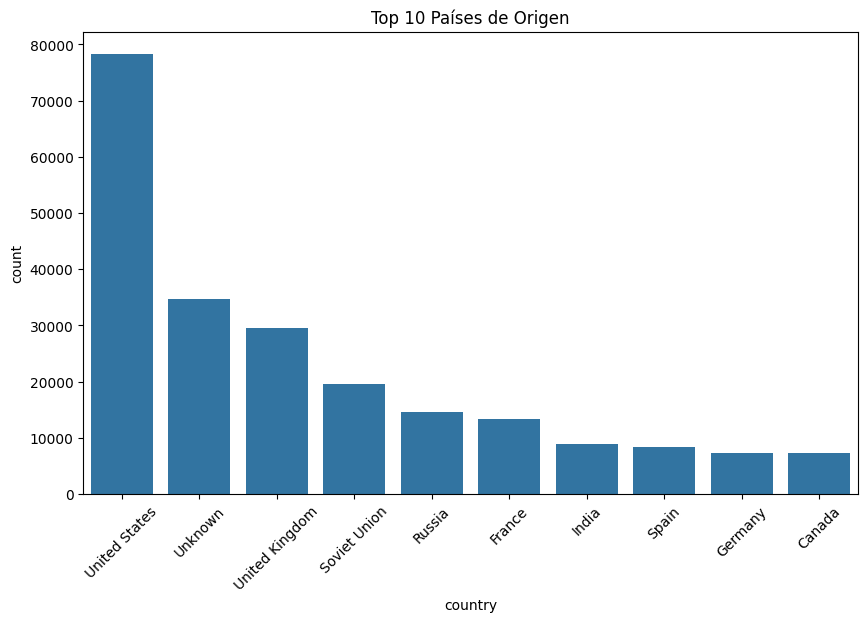

In [70]:
plt.figure(figsize=(10, 6))
sns.countplot(x='country', data=df, order=df['country'].value_counts().index[:10])
plt.title('Top 10 Países de Origen')
plt.xticks(rotation=45)
plt.show()

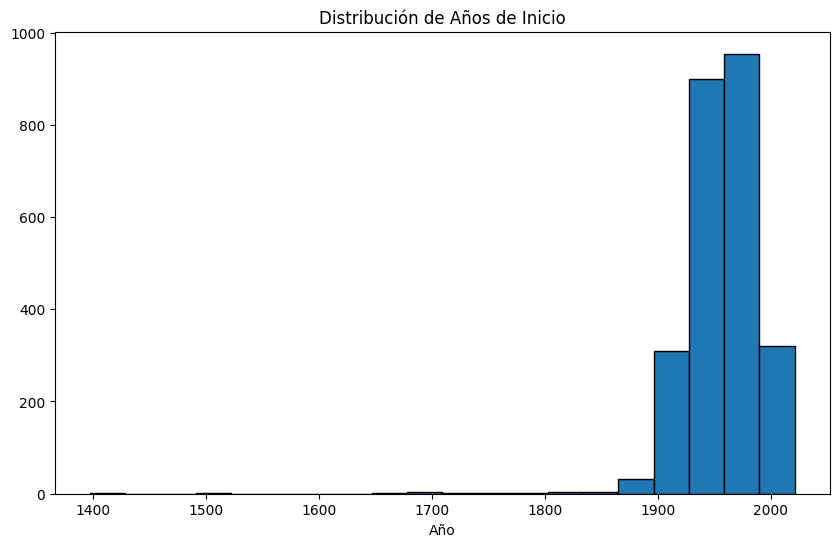

In [17]:
df['begin_year'] = pd.to_numeric(df['begin_date'].str[:4], errors='coerce')
plt.figure(figsize=(10, 6))
plt.hist(df['begin_year'].dropna(), bins=20, edgecolor='black')
plt.title('Distribución de Años de Inicio')
plt.xlabel('Año')
plt.show()

In [18]:
active_count = df['end_date'].value_counts()['Active']
print(f"Artistas activos: {active_count} ({active_count/2964*100:.2f}%)")

Artistas activos: 2143 (72.30%)


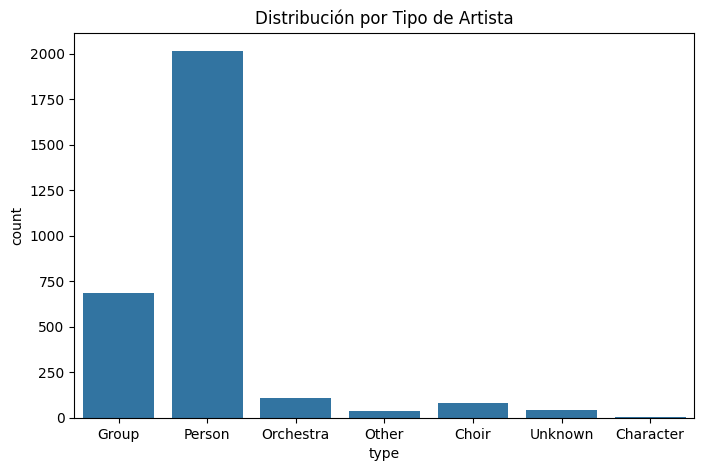

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x='type', data=df)
plt.title('Distribución por Tipo de Artista')
plt.show()

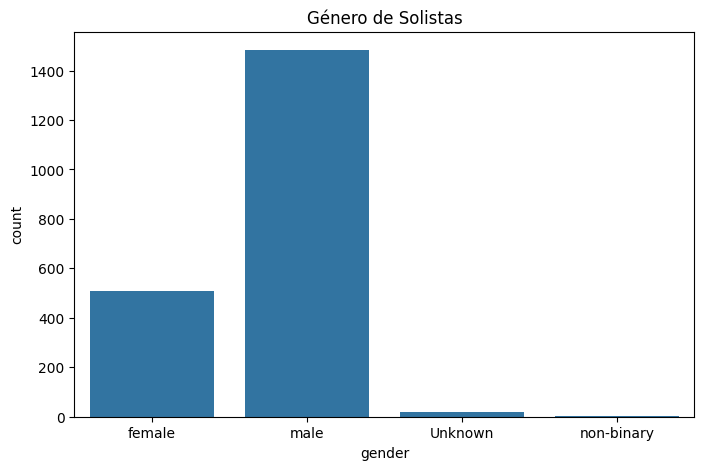

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', data=df[df['type'] == 'Person'])
plt.title('Género de Solistas')
plt.show()

<Figure size 1200x800 with 0 Axes>

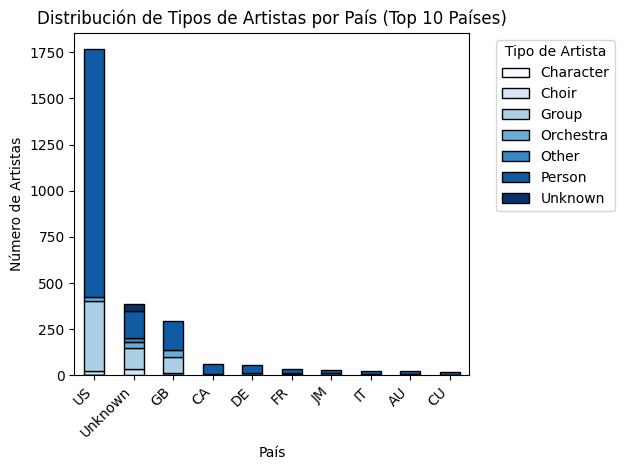

In [21]:
# Crear tabla cruzada con conteos (no normalizada para conteo absoluto)
cross_tab = pd.crosstab(df['country'], df['type'])

# Filtrar los 10 países con más artistas para mayor claridad
top_countries = cross_tab.sum(axis=1).nlargest(10).index
cross_tab_top = cross_tab.loc[top_countries]

# Graficar barras apiladas
plt.figure(figsize=(12, 8))
cross_tab_top.plot(kind='bar', stacked=True, colormap='Blues', edgecolor='black')
plt.title('Distribución de Tipos de Artistas por País (Top 10 Países)')
plt.xlabel('País')
plt.ylabel('Número de Artistas')
plt.legend(title='Tipo de Artista', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()